In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy.distance import geodesic

In [3]:
test = pd.read_csv('../data/ais_test.csv', sep=',')
train = pd.read_csv('../data/ais_train.csv', sep='|')
ids = test['vesselId'].unique()
print(f"Number of unique vessels, test: {len(ids)}")
print(f"Number of unique vessels, train: {len(train['vesselId'].unique())}")

Number of unique vessels, test: 215
Number of unique vessels, train: 688


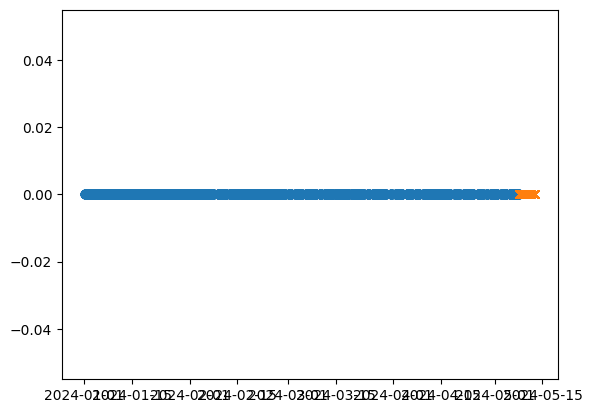

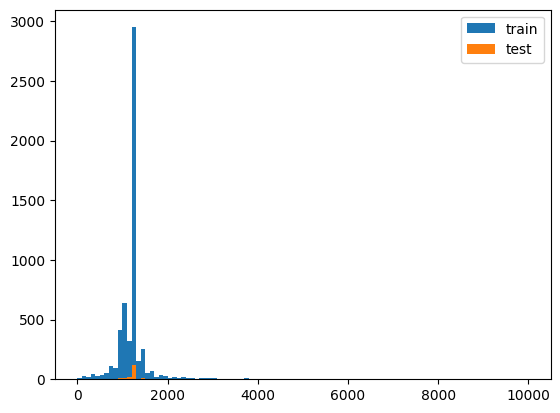

In [26]:
id = ids[5]

times_train = train[train['vesselId'] == id]['time']
times_test = test[test['vesselId'] == id]['time']


times_train = pd.to_datetime(times_train)
times_test = pd.to_datetime(times_test)

times_train = times_train.sort_values()
times_test = times_test.sort_values()

# plot the data
plt.plot(times_train, np.zeros(times_train.shape), 'o')
plt.plot(times_test, np.zeros(times_test.shape), 'x')
plt.show()

# plot the time difference for each pair of consecutive points
time_diff_train = times_train.diff().dt.total_seconds()
time_diff_test = times_test.diff().dt.total_seconds()

# make a histogram of the time differences
plt.hist(time_diff_train, bins=100, range=(0, 10000))
plt.hist(time_diff_test, bins=100, range=(0, 10000))
plt.legend(['train', 'test'])
plt.show()

## Testing data preperation

In [2]:
def progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=100, fill='█', printEnd="\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end=printEnd)
    # Print New Line on Complete
    if iteration == total:
        print()

In [128]:
def geodesic_distance(y_true, y_pred):
    distances = []
    for true, pred in zip(y_true, y_pred):
        distance = geodesic((true[0], true[1]), (pred[0], pred[1])).kilometers
        distances.append(distance)
    return np.mean(distances)

In [ ]:
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

pd.options.mode.chained_assignment = None

train_stripped = train[['time', 'vesselId', 'latitude', 'longitude']]
ids = train['vesselId'].unique()
window_size = 20

X_list = []
Y_list = []

for j, vessel_id in enumerate(ids):
    train_id = train_stripped[train_stripped['vesselId'] == vessel_id].copy()

    # Convert 'time' to seconds since 2024-01-01
    train_id['time_newyear'] = pd.to_datetime(train_id['time'])
    train_id['time_newyear'] = (train_id['time_newyear'] - pd.Timestamp('2024-01-01')).dt.total_seconds()

    # Sort by time
    train_id = train_id.sort_values('time_newyear').reset_index(drop=True)

    # Extract the rolling window data
    if len(train_id) > window_size:
        windows = sliding_window_view(train_id[['time_newyear', 'latitude', 'longitude']].values, (window_size+1, 3))
        for window in windows:
            window = window[0]
            window_stacked = np.vstack((window[:-1], np.array([window[-1][0], 0, 0])))
            print(window_stacked.shape)
            X_list.append(window_stacked)  # Features
            Y_list.append(window[-1][1:])

    # Show progress
    progress_bar(j, len(ids))

X = np.array(X_list)
Y = np.array(Y_list)


(1206659, 63)
(1206659, 2)


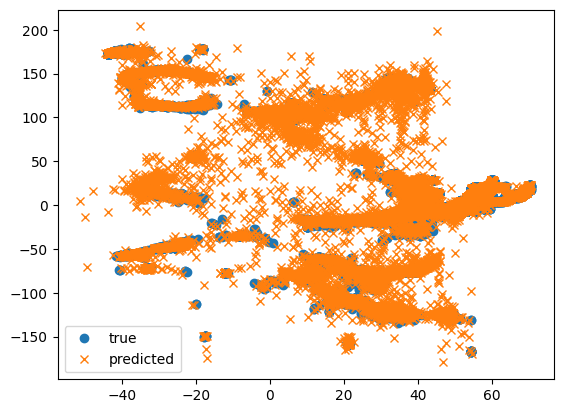

Mean squared error: 6.055054618652367


In [86]:
# fit an xgboost model and make a prediction
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.reshape(-1, 3*(window_size+1)).shape)
print(Y_train.shape)

model = XGBRegressor(objective='reg:squarederror', n_estimators=400, max_depth=9, tree_method='gpu_hist')
model.fit(X_train.reshape(-1, 3*(window_size+1)), Y_train, verbose=True)

Y_pred = model.predict(X_val.reshape(-1, 3*(window_size+1))).reshape(-1, 2)

# plot the prediction
plt.plot(Y_val[:, 0], Y_val[:, 1], 'o')
plt.plot(Y_pred[:, 0], Y_pred[:, 1], 'x')
plt.legend(['true', 'predicted'])
plt.show()

# calculate the mean squared error
from sklearn.metrics import mean_squared_error

geodesic_loss = geodesic_distance(Y_val, Y_pred)
print(f"Geodesic loss: {geodesic_loss}")

## Prepare test data

In [121]:
from icecream import ic

ids_test = test['vesselId'].unique()

X_test = pd.DataFrame(columns=['time_newyear', 'latitude', 'longitude', 'vesselId'])

for j, vessel_id in enumerate(ids_test):
    test_id = test[test['vesselId'] == vessel_id].copy()

    # Convert 'time' to seconds since 2024-01-01
    test_id['time_newyear'] = pd.to_datetime(test_id['time'])
    test_id['time_newyear'] = (test_id['time_newyear'] - pd.Timestamp('2024-01-01')).dt.total_seconds()

    # Sort by time
    test_id = test_id.sort_values('time_newyear').reset_index(drop=True)

    # Same for train
    train_id = train_stripped[train_stripped['vesselId'] == vessel_id].copy()
    train_id['time_newyear'] = pd.to_datetime(train_id['time'])
    train_id['time_newyear'] = (train_id['time_newyear'] - pd.Timestamp('2024-01-01')).dt.total_seconds()
    train_id = train_id.sort_values('time_newyear').reset_index(drop=True)

    # Make x_test the last ten rows of train_id
    X_id = train_id.tail(window_size)[['time_newyear', 'latitude','longitude', 'vesselId']].copy()

    for i in range(len(test_id)):
        test_time = test_id.iloc[i]['time_newyear']
        window = pd.concat([X_id[i:], pd.DataFrame([[test_time, 0, 0]], columns=['time_newyear', 'latitude', 'longitude'])], ignore_index=True)
        window = window[['time_newyear', 'latitude', 'longitude']].values
        window = window.reshape(1, -1)
        prediction = model.predict(window)
        
        X_id = pd.concat([X_id, pd.DataFrame([[test_time, prediction[0][0], prediction[0][1], vessel_id]], columns=['time_newyear', 'latitude', 'longitude', 'vesselId'])], ignore_index=True)

    X_test = pd.concat([X_test, X_id], ignore_index=True)

    progress_bar(j, len(ids_test))

C:\Users\Simen\AppData\Local\Temp\ipykernel_24580\998455650.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_test = pd.concat([X_test, X_id], ignore_index=True)


In [122]:
# save the predictions
X_test.to_csv('predictions.csv', index=False)

In [123]:
# given a df with columns ID, time and vesselId. Find the already predicted values in X_test corresponding to the times in the df. Return a new df with ID and the predicted values
def get_predictions(df, preds_raw):
    df['time_newyear'] = pd.to_datetime(df['time'])
    df['time_newyear'] = (df['time_newyear'] - pd.Timestamp('2024-01-01')).dt.total_seconds()
    df = df.sort_values('time_newyear').reset_index(drop=True)


    preds = np.zeros((len(df), 2))
    ids = []

    for i in range(len(df)):
        time = df.iloc[i]['time_newyear']
        vessel_id = df.iloc[i]['vesselId']
        id = df.iloc[i]['ID']

        pred = preds_raw[(preds_raw['time_newyear'] == time) & (preds_raw['vesselId'] == vessel_id)]
        if len(pred) == 0:
            ic(time)
            ic(vessel_id)
            ic(id)
            ic(i)
            break

        preds[i,:] = pred[['latitude', 'longitude']].values

        ids.append(id)

        progress_bar(i, len(df))

    return pd.DataFrame({'ID': ids, 'latitude': preds[:, 0], 'longitude': preds[:, 1]})


test = pd.read_csv('ais_test.csv', sep=',')
predictions_loaded = pd.read_csv('predictions.csv')


predictions = get_predictions(test, predictions_loaded)

   ID   latitude   longitude█████████████████████████████████████████████████████████████████████████-| 100.0% 
0   0  31.413275  -81.325386
1   1  14.670682  120.474358
2   2  38.511734   10.046206
3   3 -43.557819  172.814941
4   4  48.196682   -6.128011


In [125]:
# change colnames to from longitude and latitude to longitude_predicted and latitude_predicted
predictions.columns = ['ID', 'latitude_predicted', 'longitude_predicted']

# save the predictions
predictions.to_csv('submission.csv', index=False)

## Vol 2

Things to improve:

- Correct loss function
- More features
- Model tuning

### Extra features

- Make models to predict SOG, COG, NAVSTAT, portid
- Add vessel information
- Add port information

### Models to predict SOG, COG, NAVSTAT, portid

#### SOG

- Predictors: lat, lon, cog, vesseltypes, navstat, CEU, length, time_newyear, month, day, hour, min_delta

In [9]:
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

pd.options.mode.chained_assignment = None

def create_dataset_for_target(train_data, vessel_data_dict, target_col, window_size=10):
    """
    Creates feature matrix X and target vector Y for the given target column.

    Parameters:
    train_data (DataFrame): The dataset containing the raw training data.
    vessel_data_dict (dict): A dictionary containing pre-processed vessel-specific data.
    target_col (str): The name of the target column ('cog', 'sog', or 'navstat').
    window_size (int): The sliding window size for creating time-series features.

    Returns:
    X (numpy.ndarray): The feature matrix.
    Y (numpy.ndarray): The target vector.
    """
    X_list = []
    Y_list = []

    # Copy the training data to avoid modifying the original
    train_stripped = train_data.copy()

    # Pre-convert time to datetime for the entire dataset to avoid repeating inside the loop
    train_stripped['time'] = pd.to_datetime(train_stripped['time'])
    train_stripped['time_newyear'] = (train_stripped['time'] - pd.Timestamp('2024-01-01')).dt.total_seconds() / 60
    train_stripped['month'] = train_stripped['time'].dt.month
    train_stripped['day'] = train_stripped['time'].dt.day
    train_stripped['weekday'] = train_stripped['time'].dt.weekday.astype('category').cat.codes

    # Exclude the target column from predictors
    predictors = ['latitude', 'longitude', 'cog', 'sog', 'navstat', 'time_newyear', 'min_delta', 'month', 'weekday']
    predictors.remove(target_col)

    i = 0
    for vessel_id in train_stripped['vesselId'].unique():
        # Filter the vessel-specific data
        train_id = train_stripped[train_stripped['vesselId'] == vessel_id].copy()

        # Get vessel-specific data
        vessel_data = vessel_data_dict.get(vessel_id)

        # Sort by time_newyear
        train_id = train_id.sort_values('time_newyear').reset_index(drop=True)

        # Create time delta column
        train_id['min_delta'] = train_id['time_newyear'].diff().fillna(0)

        if len(train_id) > window_size:
            windows = sliding_window_view(train_id[predictors + [target_col]].values, (window_size + 1, len(predictors) + 1))
            for window in windows:
                window = window[0]

                # Extract features (excluding the target)
                additional_data = np.hstack((np.array(list(vessel_data.values())), window[-1][-3:]))
                window_final = np.hstack((window[:-1, :-1].flatten(), additional_data))  # Exclude the last element of the target column
                X_list.append(window_final)  # Features
                Y_list.append(window[-1][-1])  # Target (e.g., cog, sog, or navstat)

        i += 1
        progress_bar(i, len(train_stripped['vesselId'].unique()))

    X = np.array(X_list)
    Y = np.array(Y_list)
    return X, Y


# Example of usage for different targets

# Pre-process vessel data only once for all vesselIds
vessel_data_all = pd.read_csv('../data/vessels.csv', sep='|')
vessel_data_all['vesselType'] = vessel_data_all['vesselType'].astype('category').cat.codes
vessel_data_dict = vessel_data_all.set_index('vesselId')[['vesselType', 'length', 'CEU']].to_dict('index')

# Prepare the training dataset
train_stripped = train[['time', 'vesselId', 'latitude', 'longitude', 'cog', 'sog', 'navstat', 'portId', 'etaRaw']]
train_stripped['navstat'] = train_stripped['navstat'].astype('category').cat.codes

# Create datasets for different targets
X_cog, Y_cog = create_dataset_for_target(train_stripped, vessel_data_dict, 'cog', window_size=10)
X_sog, Y_sog = create_dataset_for_target(train_stripped, vessel_data_dict, 'sog', window_size=10)
X_navstat, Y_navstat = create_dataset_for_target(train_stripped, vessel_data_dict, 'navstat', window_size=10)

print(X_cog.shape, Y_cog.shape)
print(X_cog)
print(Y_navstat)



 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
(1515194, 86) (1515194,)
[[-34.7437  -57.8513    0.7     ...   1.        0.      131.1    ]
 [-35.16787 -56.7721   14.2     ...   1.        0.      144.9    ]
 [-35.16863 -56.63185  14.3     ...   1.        0.      145.3    ]
 ...
 [ 36.45456 143.44602  17.      ...   5.        5.       57.7    ]
 [ 36.49301 143.51977  16.9     ...   5.        5.       58.7    ]
 [ 36.53103 143.60055  16.8     ...   5.        5.       59.8    ]]
[0. 0. 0. ... 0. 0. 0.]


In [10]:
# save the datasets as zip files in ../data
np.savez_compressed('../data/X_cog.npz', X_cog)
np.savez_compressed('../data/Y_cog.npz', Y_cog)
np.savez_compressed('../data/X_sog.npz', X_sog)
np.savez_compressed('../data/Y_sog.npz', Y_sog)
np.savez_compressed('../data/X_navstat.npz', X_navstat)
np.savez_compressed('../data/Y_navstat.npz', Y_navstat)

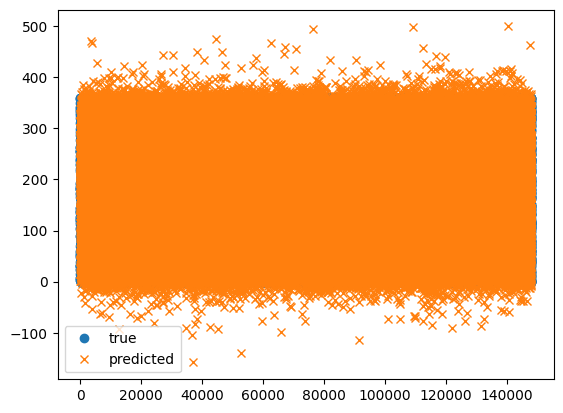

MSE: 4578.575488547183


In [151]:
# fit an xgboost model and make a prediction
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

model = XGBRegressor(objective='reg:squarederror', n_estimators=400, max_depth=9, tree_method='hist')
model.fit(X_train, Y_train, verbose=True, eval_set=[(X_val, Y_val)])

Y_pred = model.predict(X_val)

# plot the prediction
plt.plot(Y_val, 'o')
plt.plot(Y_pred, 'x')
plt.legend(['true', 'predicted'])
plt.show()

# calculate the mean squared error
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y_val, Y_pred)
print(f"MSE: {mse}")

78
76


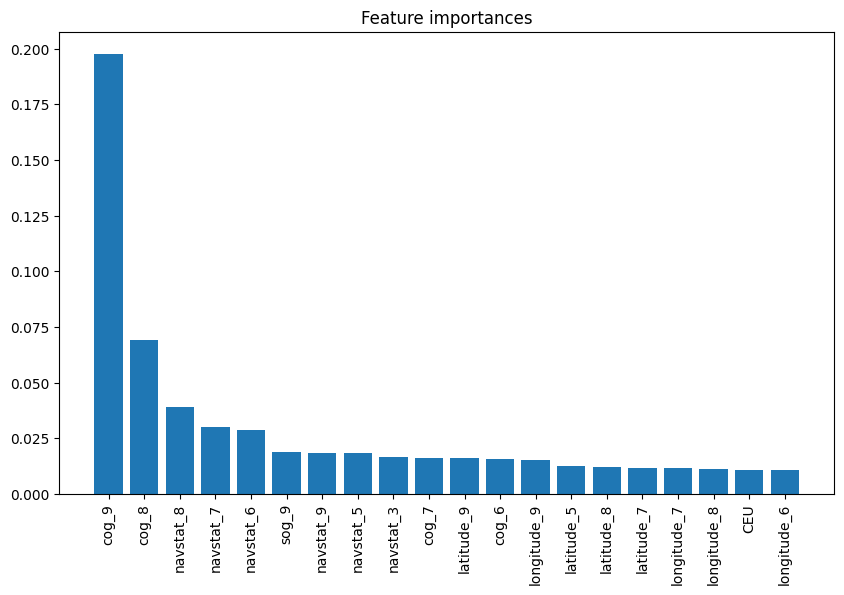

In [158]:
# importances
importances = model.feature_importances_
print(len(importances))
print(7*window_size + 6)
indices = np.argsort(importances)[::-1]

feature_names_template = []
for i in range(window_size):
    feature_names_template += [f'latitude_{i}', f'longitude_{i}', f'cog_{i}', f'sog_{i}', f'navstat_{i}', f'time_newyear_{i}', f'min_delta_{i}', f'month_{i}', f'day_{i}', f'hour_{i}']

feature_names = feature_names_template + ['vesselType', 'length', 'CEU', 'time_newyear','min_delta', 'month', 'day', 'hour']

# plot the top 20 most important features and their names
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(20), importances[indices][:20])
plt.xticks(range(20), np.array(feature_names)[indices][:20], rotation=90)
plt.show()

In [21]:
# optimize the hyperparameters using optuna, use cross-validation and input the validation set during training
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 40, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
        'tree_method': 'hist',
        'objective': 'reg:squarederror'
    }

    model = XGBRegressor(**params, early_stopping_rounds=10)
    scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')
    return scores.mean()

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

print(study.best_params)





[I 2024-10-11 11:12:32,495] A new study created in memory with name: no-name-051f1db8-e98c-4572-996f-3bbc22f05334
C:\Users\Simen\AppData\Local\Temp\ipykernel_9748\1546040640.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),
C:\Users\Simen\AppData\Local\Temp\ipykernel_9748\1546040640.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1),
C:\Users\Simen\AppData\Local\Temp\ipykernel_9748\1546040640.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use 

NameError: name 'XGBRegressor' is not defined

## LSTM

### Loss functions

In [131]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Custom geodesic loss function for latitude and longitude (lat/lon)
def custom_geodesic_loss(y_true, y_pred):
    def geodesic_distance(lat1, lon1, lat2, lon2):
        return geodesic((lat1, lon1), (lat2, lon2)).meters

    lat_true, lon_true = y_true[:, 0], y_true[:, 1]
    lat_pred, lon_pred = y_pred[:, 0], y_pred[:, 1]

    # Compute the geodesic distance for each pair of points
    distances = tf.map_fn(
        lambda x: tf.cast(tf.numpy_function(geodesic_distance, [x[0], x[1], x[2], x[3]], tf.float64), tf.float32),
        (lat_true, lon_true, lat_pred, lon_pred),
        dtype=tf.float32
    )

    return tf.reduce_mean(distances)

# Custom loss for COG and SOG (combined)
def cog_sog_loss(y_true, y_pred):
    # Split the true and predicted values for COG and SOG
    cog_true, sog_true = y_true[:, 0], y_true[:, 1]
    cog_pred, sog_pred = y_pred[:, 0], y_pred[:, 1]

    # Ensure COG is in [0, 360) by using modulo
    cog_pred = tf.math.floormod(cog_pred, 360)
    cog_loss = K.mean(K.square(cog_true - cog_pred))

    # Ensure SOG is in R+ (positive real numbers)
    sog_pred = K.maximum(sog_pred, 0)
    sog_loss = K.mean(K.square(sog_true - sog_pred))

    # Return the combined COG and SOG loss
    return cog_loss + sog_loss

# Loss for Navstat classification
def navstat_loss(y_true, y_pred):
    # Categorical cross-entropy for navstat (classification)
    return K.categorical_crossentropy(y_true, y_pred)

# Accuracy metric for Navstat classification
def navstat_accuracy(y_true, y_pred):
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1)
    return K.mean(K.equal(y_true, y_pred))

# MAE metric for COG and SOG
def cog_sog_mae(y_true, y_pred):
    cog_true, sog_true = y_true[:, 0], y_true[:, 1]
    cog_pred, sog_pred = y_pred[:, 0], y_pred[:, 1]

    # Ensure COG is in [0, 360) by using modulo
    cog_pred = tf.math.floormod(cog_pred, 360)
    cog_mae = K.mean(K.abs(cog_true - cog_pred))

    # Ensure SOG is in R+ (positive real numbers)
    sog_pred = K.maximum(sog_pred, 0)
    sog_mae = K.mean(K.abs(sog_true - sog_pred))

    return (cog_mae + sog_mae) / 2

In [45]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from icecream import ic


# Helper function to create sequences for LSTM training
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x_seq = data[i:i + seq_length]
        y_seq = data[i + seq_length]  # Predict next step
        xs.append(x_seq)
        ys.append(y_seq)
    return np.array(xs), np.array(ys)


# Feature engineering: Add time-related features and merge vessel data
def preprocess_data(ais_train, vessels):
    # Convert 'time' to datetime format
    ais_train['time'] = pd.to_datetime(ais_train['time'])

    # remoce all vessels with less than 10 observations
    ais_train = ais_train.groupby('vesselId').filter(lambda x: len(x) > 10)

    # Sort by vesselId and time to ensure correct order before calculating time delta
    ais_train = ais_train.sort_values(by=['vesselId', 'time'])

    vesselId = ais_train['vesselId'].unique()

    # Calculate time_delta (time difference between consecutive measurements for the same vessel)
    ais_train['time_delta'] = ais_train.groupby('vesselId')['time'].diff().dt.total_seconds() / 60

    # Extract other time-based features
    ais_train['month'] = ais_train['time'].dt.month
    ais_train['hour'] = ais_train['time'].dt.hour
    ais_train['weekday'] = ais_train['time'].dt.weekday

    # make a dictionary with vesselId as key and a unique number as value
    vesselId_dict = {vesselId[i]: i for i in range(len(vesselId))}
    ais_train['vessel_embedding'] = ais_train['vesselId'].map(vesselId_dict)

    # Merge vessel data (on vesselId) to add CEU, length, vesselType
    ais_train = ais_train.merge(vessels[['vesselId', 'CEU', 'length', 'vesselType']], on='vesselId', how='left')

    # all the missing values for vesselType are made into a new category
    ais_train['vesselType'] = ais_train['vesselType'].fillna(-1)

    # Handle missing values after merging, if necessary
    ais_train.fillna(0, inplace=True)

    return ais_train, vesselId_dict



# Multi-output model with appropriate activations for each task
def build_lstm_model(seq_length, num_features, num_navstat_classes):
    # Input layer
    inputs = Input(shape=(seq_length, num_features))

    # LSTM layers
    x = LSTM(units=64, return_sequences=True)(inputs)
    x = LSTM(units=32)(x)

    # Latitude and Longitude (continuous outputs)
    lat_lon_output = Dense(units=2, activation=None, name='lat_lon')(x)  # No activation, continuous output

    # COG (0-360) and SOG (non-negative) predictions (continuous)
    cog_sog_output = Dense(units=2, activation=None, name='cog_sog')(x)  # COG can be constrained in the loss function

    # Navstat (categorical output with softmax activation)
    navstat_output = Dense(units=num_navstat_classes, activation='softmax', name='navstat')(x)  # Categorical output

    # Define the model with multiple outputs
    model = Model(inputs=inputs, outputs=[lat_lon_output, cog_sog_output, navstat_output])

    return model



# Train LSTM model
def train_lstm_model(X_train, y_train, X_val, y_val, seq_length, num_features, num_navstat_classes, epochs=10, batch_size=128):
    model = build_lstm_model(seq_length, num_features, num_navstat_classes)
    # Compile with custom loss for training, but show geodesic loss on validation
    # Compile the model with different loss functions for each output
    model.compile(
        optimizer='adam',
        loss={
            'lat_lon': 'mse',   # Custom geodesic loss for latitude and longitude
            'cog_sog': 'mse',           # Custom loss for COG and SOG (regression)
            'navstat': navstat_loss            # Categorical cross-entropy for navstat (classification)
        },
        metrics={
            'lat_lon': 'mae',
            'cog_sog': 'mae'
        },
        loss_weights={'lat_lon': 8, 'cog_sog': 1, 'navstat': 500}
    )
    model.summary()

    if X_val is not None and y_val is not None:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    else:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    return model


### Prepare data

In [43]:
import pickle

# Helper function to create sequences per vessel and split based on time (80% train, 20% validation)
def create_sequences_and_split_by_time(data, seq_length, vessel_col='vesselId', split_ratio=0.8):
    X_train, X_val, y_train, y_val, x_final, x_final_train = [], [], [], [], [], []

    # find column index of 'navstat_15'
    end_idx = data.columns.get_loc('navstat_15')
    print(data.columns)
    print(data.head())

    # Group by vesselId to create sequences per vessel
    j = 0
    for vessel_id, vessel_data in data.groupby(vessel_col):
        vessel_data = vessel_data.values  # Convert to numpy array

        # Calculate the split index for the vessel (80% train, 20% validation)
        split_idx = int(len(vessel_data) * split_ratio)

        # Generate sequences for training (first 80% of the data)
        for i in range(split_idx - seq_length):
            features_history = vessel_data[i:i + seq_length,:-1]
            features_current = vessel_data[i + seq_length,:-1]

            y_data = features_current[1:(end_idx+1)].copy()
            y_train.append(y_data)  # Target sequence (next step)

            x_data = features_current.copy()

            if i == split_idx - seq_length - 1:
                x_final_train.append([np.vstack([features_history, x_data]), vessel_data[i + seq_length, -1]])

            x_data[1:(end_idx+1)] = 0
            X_train.append(np.vstack([features_history, x_data]))

        # Generate sequences for validation (last 20% of the data)
        for i in range(split_idx, len(vessel_data) - seq_length):
            features_history = vessel_data[i:i + seq_length,:-1]
            features_current = vessel_data[i + seq_length,:-1]

            y_data = features_current[1:(end_idx+1)].copy()
            y_val.append(y_data)

            x_data = features_current.copy()

            if i == len(vessel_data) - seq_length - 1:
                x_final.append([np.vstack([features_history, x_data]), vessel_data[i + seq_length, -1]])

            x_data[1:(end_idx+1)] = 0
            X_val.append(np.vstack([features_history, x_data]))

        j += 1
        progress_bar(j, len(data[vessel_col].unique()))

    # Convert to numpy arrays
    return np.array(X_train), np.array(X_val), np.array(y_train), np.array(y_val), x_final, x_final_train

# Prepare training data (sequences) while ensuring sequential split by time within each vessel
def prepare_training_data_with_time_split(data, continuous_features_hidden, continuous_features_open, categorical_features, seq_length=10, split_ratio=0.8):

    continuous_features = continuous_features_hidden + continuous_features_open
    n_continuous_hidden = len(continuous_features_hidden)
    
    # Select the continuous features that need scaling
    scaler = StandardScaler()
    continuous_data_scaled = scaler.fit_transform(data[continuous_features])

    # Get navstat dummy columns
    navstat_dummies = pd.get_dummies(data['navstat'], prefix='navstat')

    # make all the categorical features into one-hot encoding
    data = pd.get_dummies(data, columns=categorical_features)

    # move time to the end
    data = pd.concat([data.drop('time', axis=1), data['time']], axis=1)

    
    # Concatenate continuous and categorical data together to a dataframe
    data_scaled = pd.concat([pd.DataFrame(continuous_data_scaled[:,:n_continuous_hidden], columns=continuous_features_hidden),
                             navstat_dummies,
                             pd.DataFrame(continuous_data_scaled[:,n_continuous_hidden:], columns=continuous_features_open),
                             data.drop(continuous_features + ['navstat'], axis=1)], axis=1)

    # Put 'vesselId' as the first column
    data_scaled = pd.concat([data_scaled['vesselId'], data_scaled.drop('vesselId', axis=1)], axis=1)
    
    # Create sequences for LSTM training, ensuring 80% train and 20% validation per vessel
    X_train, X_val, y_train, y_val, x_final, x_final_train = create_sequences_and_split_by_time(
        data_scaled, seq_length, split_ratio=split_ratio)
    
    return X_train, X_val, y_train, y_val, x_final, x_final_train, scaler

def get_train_val_data(data: pd.DataFrame, continuous_features: list, split_ratio: float, scale: bool = True):
    """
    Input big dataset. The fuction filters for each vesselId, sorts this filtered df by time, selects the first 80% of the data for training and the last 20% for validation.
    Returns the training and validation data.
    """
    # get unique vesselIds
    vesselIds = data['vesselId'].unique()

    # create empty lists to store the training and validation data
    train_data = []
    val_data = []

    # loop through each vesselId
    for vesselId in vesselIds:
        # filter the data for the current vesselId
        vessel_data = data[data['vesselId'] == vesselId]

        # sort the data by time
        vessel_data = vessel_data.sort_values('time')

        # get the index for the 80% split
        split_idx = int(len(vessel_data) * split_ratio)

        train_vessel_data = vessel_data[:split_idx]
        val_vessel_data = vessel_data[split_idx:]

        if len(train_vessel_data) == 0 or len(val_vessel_data) == 0:
            print(f"Warning: Vessel {vesselId} has an empty set in either training or validation. Total records: {len(vessel_data)}")
        else:
            train_data.append(train_vessel_data)
            val_data.append(val_vessel_data)


    # concatenate the training and validation data
    train_data = pd.concat(train_data)
    val_data = pd.concat(val_data)

    if scale:
        scaler = StandardScaler()
        train_data[continuous_features] = scaler.fit_transform(train_data[continuous_features])

        # make it a df again
        train_data = pd.DataFrame(train_data, columns=data.columns)

    else:
        scaler = None

    return train_data, val_data, scaler

def format_val_data(val_data):
    """
    Given the validation data, make a stripped df with only vesselId and time and ID
    Also, make a new df with ID, latitude and longitude.
    """
    # make a stripped df with only vesselId and time
    stripped_val_data = val_data[['vesselId', 'time']]

    # add an ID column
    stripped_val_data['ID'] = stripped_val_data.index

    # make a new df with ID, latitude and longitude
    y_val = val_data[['latitude', 'longitude']]
    y_val['ID'] = y_val.index

    return stripped_val_data, y_val

def sort_features(data, continuous_features_hidden, continuous_features_open, categorical_features):
    continuous_features = continuous_features_hidden + continuous_features_open
    n_continuous_hidden = len(continuous_features_hidden)
    
    continuous_data = np.array(data[continuous_features].copy())

    # Get navstat dummy columns
    navstat_dummies = pd.get_dummies(data['navstat'], prefix='navstat')

    # set all that have navstat_8 to have navstat_0 instead
    navstat_dummies['navstat_0'] = navstat_dummies['navstat_8'] + navstat_dummies['navstat_0']
    navstat_dummies['navstat_15'] = (navstat_dummies['navstat_11'] + navstat_dummies['navstat_12'] + navstat_dummies['navstat_13']
                                    + navstat_dummies['navstat_14'] + navstat_dummies['navstat_7'] + navstat_dummies['navstat_9'])
    navstat_dummies = navstat_dummies.drop(['navstat_8', 'navstat_11', 'navstat_12', 'navstat_13', 'navstat_14', 'navstat_7', 'navstat_9'], axis=1)

    # make all the categorical features into one-hot encoding
    data = pd.get_dummies(data, columns=categorical_features)

    # move time to the end
    data = pd.concat([data.drop('time', axis=1), data['time']], axis=1)

    # Concatenate continuous and categorical data together to a dataframe
    data_concat = pd.concat([pd.DataFrame(continuous_data[:,:n_continuous_hidden].copy(), columns=continuous_features_hidden),
                             navstat_dummies.copy(),
                             pd.DataFrame(continuous_data[:,n_continuous_hidden:].copy(), columns=continuous_features_open),
                             data.drop(continuous_features + ['navstat'], axis=1).copy()], axis=1)
    
    # delete data, navstat_dummies, continuous_data to save memory
    del data, navstat_dummies, continuous_data

    # Put 'vesselId' as the first column
    data_concat = pd.concat([data_concat['vesselId'], data_concat.drop('vesselId', axis=1)], axis=1)

    return data_concat



def create_sequences_and_split_by_time_debug(data_train, seq_length, data_val = None, vessel_col='vesselId'):
    X_train, y_train, x_val, y_val, x_final_train = [], [], [], [], []

    # find column index of 'navstat_15'
    end_idx = data_train.columns.get_loc('time_delta')
    print(data_train.columns)
    print(data_train.head())

    # Group by vesselId to create sequences per vessel
    j = 0
    n_iter = len(data_train[vessel_col].unique())
    print(n_iter)
    for vessel_id, vessel_data in data_train.groupby(vessel_col):


        vessel_data = vessel_data.values  # Convert to numpy array

        # Generate sequences for training
        for i in range(len(vessel_data) - seq_length):
            features_history = vessel_data[i:i + seq_length,1:(end_idx+1)]
            features_current = vessel_data[i + seq_length,1:-1]

            y_data = features_current[:(end_idx-1)].copy()
            y_train.append(y_data)  # Target sequence (next step)

            x_data = features_current.copy()

            if i == len(vessel_data) - seq_length - 1:

                x_final_train.append([np.hstack([features_history.flatten(), x_data]), vessel_data[i:(i + seq_length+1), -1]])

            # flatten the features_history and add x_data[21:] to it
            X_train.append(np.hstack([features_history.flatten(), x_data[(end_idx-1):]]))

        j += 1
        progress_bar(j, n_iter)

    # save x_train and y_train
    X_train = np.array(X_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32)
    np.savez_compressed('../data/xgb/X_train.npz', X_train)
    np.savez_compressed('../data/xgb/y_train.npz', y_train)

    # save x_final_train
    with open('../data/xgb/x_final_train.pkl', 'wb') as f:
        pickle.dump(x_final_train, f)

    # delete X_train and y_train to save memory
    del X_train, y_train

    if data_val is None:
        return x_final_train

    j = 0
    n_iter = len(data_val[vessel_col].unique())
    for vessel_id, vessel_data in data_val.groupby(vessel_col):
        vessel_data = vessel_data.values  # Convert to numpy array

        # Generate sequences for validation
        for i in range(len(vessel_data) - seq_length):
            features_history = vessel_data[i:i + seq_length,1:(end_idx+1)]
            features_current = vessel_data[i + seq_length,1:-1]

            y_data = features_current[:(end_idx-1)].copy()
            y_val.append(y_data)  # Target sequence (next step)

            x_data = features_current.copy()

            # flatten the features_history and add x_data[21:] to it
            x_val.append(np.hstack([features_history.flatten(), x_data[(end_idx-1):]]))

        j += 1
        progress_bar(j, n_iter)

    # save x_val and y_val
    x_val = np.array(x_val, dtype=np.float32)
    y_val = np.array(y_val, dtype=np.float32)
    np.savez_compressed('../data/xgb/X_val.npz', x_val)
    np.savez_compressed('../data/xgb/y_val.npz', y_val)

    


## Nye features

In [192]:
# Load data

ais_train = pd.read_csv('../data/ais_train.csv', sep='|')  # Adjust file path
vessels = pd.read_csv('../data/vessels.csv', sep='|')  # Adjust file path

print(ais_train['vesselId'].nunique())

# Preprocess and engineer features
ais_train, vessel_dict = preprocess_data(ais_train, vessels)

688


In [193]:
# Prepare features and labels for LSTM
features = ['vesselId', 'latitude', 'longitude', 'cog', 'sog', 'navstat', 'time_delta', 'month', 'hour', 'weekday', 'CEU', 'length', 'vesselType', 'vessel_embedding', 'time']
continuous_features_hidden = ['latitude', 'longitude', 'cog', 'sog']
continuous_features_open = ['time_delta', 'CEU', 'length', 'vessel_embedding']
categorical_features = ['month', 'hour', 'weekday', 'vesselType']  # Keep these as is for now
seq_length = 10
ais_train = ais_train[features]  # Filter to selected features

In [194]:
data_concat = sort_features(ais_train, continuous_features_hidden, continuous_features_open, categorical_features)
print(data_concat.columns)
print(data_concat['vessel_embedding'])

Index(['vesselId', 'latitude', 'longitude', 'cog', 'sog', 'navstat_0',
       'navstat_1', 'navstat_2', 'navstat_3', 'navstat_4', 'navstat_5',
       'navstat_6', 'navstat_15', 'time_delta', 'CEU', 'length',
       'vessel_embedding', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'vesselType_-1.0', 'vesselType_14.0', 'vesselType_21.0',
       'vesselType_83.0', 'time'],
      dtype='object')
0          599.0
1          599.0
2          599.0
3          599.0
4          599.0
           ...  
1522060    269.0
1522061    269.0
1522062    269.0
1522063    269.0
1522064    269.0
Name: vessel_embedding

In [195]:
continuous_features = continuous_features_hidden + continuous_features_open
print(data_concat['vesselId'].nunique())
X_train, X_val_raw, scaler = get_train_val_data(data_concat, continuous_features, split_ratio=0.8, scale=False)

688


In [196]:
X_train['vesselId'].nunique()

687

In [197]:
X_val_raw['vesselId'].nunique()

687

In [198]:
create_sequences_and_split_by_time_debug(X_train, X_val_raw, seq_length)

Index(['vesselId', 'latitude', 'longitude', 'cog', 'sog', 'navstat_0',
       'navstat_1', 'navstat_2', 'navstat_3', 'navstat_4', 'navstat_5',
       'navstat_6', 'navstat_15', 'time_delta', 'CEU', 'length',
       'vessel_embedding', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'vesselType_-1.0', 'vesselType_14.0', 'vesselType_21.0',
       'vesselType_83.0', 'time'],
      dtype='object')
                   vesselId  latitude  longitude    cog   sog  navstat_0  \
0  61e9f38eb937134a3c4bfd8b   7.50361   77.58340  308.1  17.1       True   
1  61e9f38eb937134a3c4bfd8b   7.57302   77.49505  307.6  

In [199]:
# save X_val_raw
stripped_val_data, y_val_stripped = format_val_data(X_val_raw)
stripped_val_data.to_csv('../data/xgb/stripped_val_data.csv', index=False)
y_val_stripped.to_csv('../data/xgb/y_val_stripped.csv', index=False)

C:\Users\Simen\AppData\Local\Temp\ipykernel_9748\2983548965.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stripped_val_data['ID'] = stripped_val_data.index
C:\Users\Simen\AppData\Local\Temp\ipykernel_9748\2983548965.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_val['ID'] = y_val.index


## Nye features end

## MED ALL DATA

In [46]:
# Load data

ais_train = pd.read_csv('../data/ais_train.csv', sep='|')  # Adjust file path
vessels = pd.read_csv('../data/vessels.csv', sep='|')  # Adjust file path

# Preprocess and engineer features
ais_train, vesselId_dict = preprocess_data(ais_train, vessels)

# save vesselId_dict
with open('../data/xgb/vesselId_dict.pkl', 'wb') as f:
    pickle.dump(vesselId_dict, f)

In [47]:
# Prepare features and labels for LSTM
features = ['vesselId', 'latitude', 'longitude', 'cog', 'sog', 'navstat', 'time_delta', 'month', 'hour', 'weekday', 'CEU', 'length', 'vesselType', 'vessel_embedding', 'time']
continuous_features_hidden = ['latitude', 'longitude', 'cog', 'sog']
continuous_features_open = ['time_delta', 'CEU', 'length', 'vessel_embedding']
categorical_features = ['month', 'hour', 'weekday', 'vesselType']  # Keep these as is for now
seq_length = 10
ais_train = ais_train[features]  # Filter to selected features

In [48]:
data_concat = sort_features(ais_train, continuous_features_hidden, continuous_features_open, categorical_features)

In [49]:
data_concat[['vesselId', 'time', 'vessel_embedding']]

,vesselId,time,vessel_embedding
0,61e9f38eb937134a3c4bfd8b,2024-01-12 14:07:47,0.0
1,61e9f38eb937134a3c4bfd8b,2024-01-12 14:31:00,0.0
2,61e9f38eb937134a3c4bfd8b,2024-01-12 14:57:23,0.0
3,61e9f38eb937134a3c4bfd8b,2024-01-12 15:18:48,0.0
4,61e9f38eb937134a3c4bfd8b,2024-01-12 15:39:47,0.0
...,...,...,...
1522059,clh6aqawa0007gh0z9h6zi9bo,2024-05-07 22:36:16,686.0
1522060,clh6aqawa0007gh0z9h6zi9bo,2024-05-07 22:57:05,686.0
1522061,clh6aqawa0007gh0z9h6zi9bo,2024-05-07 23:17:54,686.0
1522062,clh6aqawa0007gh0z9h6zi9bo,2024-05-07 23:38:13,686.0


In [50]:
create_sequences_and_split_by_time_debug(data_concat, seq_length)

Index(['vesselId', 'latitude', 'longitude', 'cog', 'sog', 'navstat_0',
       'navstat_1', 'navstat_2', 'navstat_3', 'navstat_4', 'navstat_5',
       'navstat_6', 'navstat_15', 'time_delta', 'CEU', 'length',
       'vessel_embedding', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'vesselType_-1.0', 'vesselType_14.0', 'vesselType_21.0',
       'vesselType_83.0', 'time'],
      dtype='object')
                   vesselId  latitude  longitude    cog   sog  navstat_0  \
0  61e9f38eb937134a3c4bfd8b   7.50361   77.58340  308.1  17.1       True   
1  61e9f38eb937134a3c4bfd8b   7.57302   77.49505  307.6  

[[array([36.98415, 5.79426, 36.7, 0.5, True, False, False, False, False,
         False, False, False, 7.216666666666667, 36.98595, 5.79692, 69.4,
         0.1, True, False, False, False, False, False, False, False, 33.6,
         36.99575, 5.79647, 14.6, 0.3, True, False, False, False, False,
         False, False, False, 135.58333333333334, 36.99668, 5.79674, 13.4,
         0.4, True, False, False, False, False, False, False, False, 9.4,
         37.00551, 5.81394, 48.4, 0.7, True, False, False, False, False,
         False, False, False, 270.6166666666667, 36.84631, 5.84503, 71.0,
         0.0, False, True, False, False, False, False, False, False,
         257.6166666666667, 36.84636, 5.84488, 71.0, 0.0, False, True,
         False, False, False, False, False, False, 14.0, 36.84647, 5.84534,
         71.0, 0.0, False, True, False, False, False, False, False, False,
         48.81666666666667, 36.8467, 5.84588, 347.0, 0.0, False, True,
         False, False, False, False, False, Fal

## MED ALL DATA END

X_train cols: Index(['vesselId', 'latitude', 'longitude', 'cog', 'sog', 'navstat_0',
       'navstat_1', 'navstat_2', 'navstat_3', 'navstat_4', 'navstat_5',
       'navstat_6', 'navstat_7', 'navstat_8', 'navstat_9', 'navstat_11',
       'navstat_12', 'navstat_13', 'navstat_14', 'navstat_15', 'CEU', 'length',
       'time_delta', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'vesselType_-1.0', 'vesselType_14.0', 'vesselType_21.0',
       'vesselType_83.0', 'time'],
      dtype='object')

In [ ]:
# open ../data/ais_train.zip (ais_train.csv does not exist) with zipfile.ZipFile
# read the file ais_train.csv into a DataFrame

import zipfile
import pandas as pd


In [94]:
# Load data

ais_train = pd.read_csv('../data/ais_train.csv', sep='|')  # Adjust file path
vessels = pd.read_csv('../data/vessels.csv', sep='|')  # Adjust file path

# Preprocess and engineer features
ais_train = preprocess_data(ais_train, vessels)

# Prepare features and labels for LSTM
features = ['vesselId', 'latitude', 'longitude', 'cog', 'sog', 'navstat', 'time_delta', 'month', 'hour', 'weekday', 'CEU', 'length', 'vesselType', 'time']
continuous_features_hidden = ['latitude', 'longitude', 'cog', 'sog']
continuous_features_open = ['CEU', 'length']
categorical_features = ['month', 'hour', 'weekday', 'vesselType']  # Keep these as is for now
seq_length = 10
ais_train = ais_train[features]  # Filter to selected features



X_train, X_val, y_train, y_val, x_final, x_final_train, scaler = prepare_training_data_with_time_split(ais_train, continuous_features_hidden, continuous_features_open, categorical_features, seq_length=seq_length)

Index(['vesselId', 'latitude', 'longitude', 'cog', 'sog', 'navstat_0',
       'navstat_1', 'navstat_2', 'navstat_3', 'navstat_4', 'navstat_5',
       'navstat_6', 'navstat_7', 'navstat_8', 'navstat_9', 'navstat_11',
       'navstat_12', 'navstat_13', 'navstat_14', 'navstat_15', 'CEU', 'length',
       'time_delta', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'vesselType_-1.0', 'vesselType_14.0', 'vesselType_21.0',
       'vesselType_83.0', 'time'],
      dtype='object')
                   vesselId  latitude  longitude       cog       sog  \
0  61e9f38eb937134a3c4bfd8b -1.269658   0.961162  1.205

In [9]:
X_train_arr = np.array(X_train[:,:,1:], dtype=np.float32)
y_train_arr = np.array(y_train, dtype=np.float32)
X_val_arr = np.array(X_val[:,:,1:], dtype=np.float32)
y_val_arr = np.array(y_val, dtype=np.float32)

print(X_val.shape)

y_train_dict = {
    'lat_lon': y_train_arr[:, :2],  # Latitude and Longitude
    'cog_sog': y_train_arr[:, 2:4], # COG and SOG
    'navstat': y_train_arr[:, 4:]   # Navstat (one-hot encoded)
}

y_val_dict = {
    'lat_lon': y_val_arr[:, :2],  # Latitude and Longitude
    'cog_sog': y_val_arr[:, 2:4], # COG and SOG
    'navstat': y_val_arr[:, 4:]   # Navstat (one-hot encoded)
}

# Number of navstat classes (for classification)
num_navstat_classes = ais_train['navstat'].nunique()

(297840, 11, 63)


In [12]:
# Train the model on the training data
#model = train_lstm_model(X_train_arr, y_train_dict, X_val_arr, y_val_dict, seq_length+1, X_train_arr.shape[2], num_navstat_classes, epochs=2, batch_size=128)

# Merge the y_train_dict and y_val_dict to a new y_full_dict
y_full_dict = {}
for key in y_train_dict.keys():
    y_full_dict[key] = np.vstack([y_train_dict[key], y_val_dict[key]])

# Train the model on all the data
model = train_lstm_model(np.vstack([X_train_arr, X_val_arr]), y_full_dict, X_val_arr, y_val_dict, seq_length+1, X_train_arr.shape[2], num_navstat_classes, epochs=20, batch_size=128)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 11, 62)]     0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 11, 64)       32512       ['input_2[0][0]']                
                                                                                                  
 lstm_3 (LSTM)                  (None, 32)           12416       ['lstm_2[0][0]']                 
                                                                                                  
 lat_lon (Dense)                (None, 2)            66          ['lstm_3[0][0]']                 
                                                                                            

In [68]:
# save the keras model
model.save('ais_model.h5')

In [38]:
def sort_df_by_vessel_ids(df, vessel_ids):
    """
    Sort a DataFrame according to the order of a given Series of unique vessel IDs.

    Parameters:
    df (pd.DataFrame): The DataFrame to be sorted. Must contain columns 'ID', 'vesselId', and 'time'.
    vessel_ids (pd.Series): A Series containing unique vessel IDs in the desired order.

    Returns:
    pd.DataFrame: The sorted DataFrame.
    """
    # Ensure 'vesselId' column is treated as a categorical type with the order specified by vessel_ids
    df['vesselId'] = pd.Categorical(df['vesselId'], categories=vessel_ids, ordered=True)
    
    # Sort the DataFrame by 'vesselId' and 'time'
    df_sorted = df.sort_values(by=['vesselId', 'time']).reset_index(drop=True)
    
    return df_sorted

# Load test data
ais_test = pd.read_csv('../data/ais_test.csv', sep=',')  # Adjust file path

# vessel_ids is ais_train sorted by vesselId
vessel_ids = ais_train['vesselId'].unique()

# Sort the test data by vessel IDs
ais_test_sorted = sort_df_by_vessel_ids(ais_test, vessel_ids)

In [63]:
def format_prediction_output(predictions, last_known_sequence):

    n_out = [2,2,15]
    newline = last_known_sequence[0,-1,:].copy()

    k = 0
    for i in range(3):
        for j in range(n_out[i]):
            if i == 2:
                newline[k] = np.argmax(predictions[i][0]) == j
            else:
                newline[k] = predictions[i][0][j]
            k += 1
    return newline

def get_final_line(last_known_sequence, time, time_prev):
    
    # check that time and time_prev are datetime objects, if not convert them
    if not isinstance(time, pd.Timestamp):
        time = pd.Timestamp(time)
    if not isinstance(time_prev, pd.Timestamp):
        time_prev = pd.Timestamp(time_prev)

    final_line = last_known_sequence[-1].copy()
    final_line[:19] = 0
    final_line[21] = (time - time_prev).total_seconds() / 60

    # get 5 dummy variables for month
    month = time.month
    for i in range(5):
        final_line[22 + i] = month == i + 1
    
    # get 24 dummy variables for hour
    hour = time.hour
    for i in range(24):
        final_line[27 + i] = hour == i
    
    # get 7 dummy variables for weekday
    weekday = time.weekday()
    for i in range(7):
        final_line[51 + i] = weekday == i
    
    return final_line

def format_history_visual(last_known_seq):
    vesselId = last_known_seq[0][0,0]
    time = pd.to_datetime(last_known_seq[1])
    last_known_seq = last_known_seq[0][1:,1:]

    latitudes = last_known_seq[:,0]
    longitudes = last_known_seq[:,1]
    times = [time - pd.Timedelta(minutes=i*20) for i in range(len(latitudes))]
    times = times[::-1]
    history = pd.DataFrame({'time': times, 'vesselId': [vesselId for i in range(len(latitudes))], 'latitude': latitudes, 'longitude': longitudes})
    print('\nhistory:')
    print(history)

    return history



def predict_future_positions(model, test_data, x_final, seq_length=10, return_first=False):

    IDs = []
    latitudes = [] 
    longitudes = []
    times = []
    vessel_ids = []

    vesselId = ''
    formated_output = []

    # iterate over the test_data
    j = 0
    for i in range(len(test_data)):

        if test_data['vesselId'].iloc[i] != vesselId:
            vesselId = test_data['vesselId'].iloc[i]
            last_known_sequence = x_final[j][0][1:,1:]
            if j == 0:
                visualizer = format_history_visual(x_final[j])
            time_prev = x_final[j][1]
            j += 1
            if return_first and j == 2:
                result = pd.DataFrame({'ID': IDs, 'latitude': latitudes, 'longitude': longitudes})
                result = result.sort_values(by='ID').reset_index(drop=True)
                visualizer = pd.concat([visualizer, pd.DataFrame({'time': times, 'vesselId': vessel_ids, 'latitude': latitudes, 'longitude': longitudes})])
                visualizer.to_csv('../data/visualizer.csv', index=False)
                return result

        else:
            last_known_sequence = np.vstack([last_known_sequence[1:,:], np.array(formated_output)])
            time_prev = test_data.iloc[i-1]['time']


        final_line = get_final_line(last_known_sequence, test_data.iloc[i]['time'], time_prev)
        last_known_sequence = np.vstack([last_known_sequence, final_line])
        times.append(test_data.iloc[i]['time'])
        vessel_ids.append('pred_'+vesselId)


        # Predict future positions
        last_known_sequence = np.array(last_known_sequence, dtype=np.float32)  # Ensure correct dtype
        last_known_sequence = last_known_sequence.reshape(1, seq_length + 1, -1)  # Reshape to (1, seq_length + 1, num_features)
        pred = model.predict(last_known_sequence, verbose=0)

        #if i==0:
            #print(last_known_sequence)
            #print(pred)

        IDs.append(test_data.iloc[i]['ID'])
        latitudes.append(pred[0][0][0])
        longitudes.append(pred[0][0][1])
        
        formated_output = format_prediction_output(pred, last_known_sequence)
        last_known_sequence = last_known_sequence[0,1:,:]

        progress_bar(i, len(test_data))

        

    # return a dataframe sorted by ID
    result = pd.DataFrame({'ID': IDs, 'latitude': latitudes, 'longitude': longitudes})
    result = result.sort_values(by='ID').reset_index(drop=True)
    return result

# test the function
#result = predict_future_positions(model, ais_test_sorted, x_final, seq_length=10)

# save the predictions
#result.to_csv('submission_LSTM.csv', index=False)


## Debugging

In [74]:
# Load data
ais_train = pd.read_csv('../data/ais_train.csv', sep='|')  # Adjust file path
vessels = pd.read_csv('../data/vessels.csv', sep='|')  # Adjust file path

# Preprocess and engineer features
ais_train = preprocess_data(ais_train, vessels)

In [75]:
#Prepare features and labels for LSTM
features = ['vesselId', 'latitude', 'longitude', 'cog', 'sog', 'navstat', 'time_delta', 'month', 'hour', 'weekday', 'CEU', 'length', 'vesselType', 'time']
continuous_features_hidden = ['latitude', 'longitude', 'cog', 'sog']
continuous_features_open = ['time_delta', 'CEU', 'length']
categorical_features = ['month', 'hour', 'weekday', 'vesselType']  # Keep these as is for now
seq_length = 10
ais_train = ais_train[features]  # Filter to selected features

scaler = prepare_training_data_with_time_split_debug(ais_train, continuous_features_hidden, continuous_features_open, categorical_features, seq_length=seq_length, scale=False)

num_navstat_classes = ais_train['navstat'].nunique()

del ais_train, vessels

X_train cols: Index(['vesselId', 'latitude', 'longitude', 'cog', 'sog', 'navstat_0',
       'navstat_1', 'navstat_2', 'navstat_3', 'navstat_4', 'navstat_5',
       'navstat_6', 'navstat_7', 'navstat_8', 'navstat_9', 'navstat_11',
       'navstat_12', 'navstat_13', 'navstat_14', 'navstat_15', 'CEU', 'length',
       'time_delta', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'vesselType_-1.0', 'vesselType_14.0', 'vesselType_21.0',
       'vesselType_83.0', 'time'],
      dtype='object')
X_val cols: Index(['vesselId', 'latitude', 'longitude', 'cog', 'sog', 'navstat_0',
       'navstat_1', 'navstat_2

KeyboardInterrupt: 

In [ ]:
X_val_stripped, y_val_stripped = format_val_data(X_val_raw)

In [120]:
# load x_train.npz
X_train_arr = np.array(np.load('../data/LSTM/X_train.npz')['arr_0'], dtype=np.float32)
y_train_arr = np.array(y_train, dtype=np.float32)
X_val_arr = np.array(np.load('../data/LSTM/X_val.npz')['arr_0'], dtype=np.float32)
y_val_arr = np.array(y_val, dtype=np.float32)


y_train_dict = {
    'lat_lon': y_train_arr[:, :2],  # Latitude and Longitude
    'cog_sog': y_train_arr[:, 2:4], # COG and SOG
    'navstat': y_train_arr[:, 4:]   # Navstat (one-hot encoded)
}

y_val_dict = {
    'lat_lon': y_val_arr[:, :2],  # Latitude and Longitude
    'cog_sog': y_val_arr[:, 2:4], # COG and SOG
    'navstat': y_val_arr[:, 4:]   # Navstat (one-hot encoded)
}

# Number of navstat classes (for classification)
num_navstat_classes = ais_train['navstat'].nunique()

NameError: name 'ais_train' is not defined

In [ ]:
# Train the model on the training data
model = train_lstm_model(X_train_arr, y_train_dict, X_val_arr, y_val_dict, seq_length+1, X_train_arr.shape[2], num_navstat_classes, epochs=20, batch_size=128)

In [41]:
model = tf.keras.models.load_model('../models/model_LSTMv3.keras', custom_objects={'custom_geodesic_loss': custom_geodesic_loss, 'cog_sog_loss': cog_sog_loss, 'navstat_loss': navstat_loss, 'navstat_accuracy': navstat_accuracy, 'cog_sog_mae': cog_sog_mae})

In [59]:
def format_true_visual(X_val_raw, seq_length=10):
    # select the first vesselId
    vesselId = X_val_raw['vesselId'].iloc[0]
    # filter the data for the first vesselId
    vessel_data = X_val_raw[X_val_raw['vesselId'] == vesselId].iloc[seq_length:]
    # add a prefix 'true_' to the vesselId
    vessel_data['vesselId'] = 'true_' + vessel_data['vesselId']

    return vessel_data[['vesselId', 'latitude', 'longitude']]

def full_visualizer(filepath, X_val_raw):
    # Load the visualizer
    visualizer = pd.read_csv(filepath)
    # format the true visual
    true_visual = format_true_visual(X_val_raw)

    # get the times from visualizer where vesselId starts with 'pred_'
    times = visualizer[visualizer['vesselId'].str.startswith('pred_')]['time']

    # add times to true_visual
    true_visual['time'] = times

    # concatenate the two dataframes
    visualizer = pd.concat([true_visual, visualizer])

    # save the visualizer
    visualizer.to_csv('../data/visualizer_full.csv', index=False)

In [64]:
# test the function
with open('../data/LSTM/x_final_train.pkl', 'rb') as f:
    x_train_final = pickle.load(f)
X_val_stripped = pd.read_csv('../data/LSTM/stripped_val_data.csv')
X_val_raw = pd.read_csv('../data/LSTM/X_val_raw.csv')


result = predict_future_positions(model, X_val_stripped, x_train_final, seq_length=10, return_first=True)
full_visualizer('../data/visualizer.csv', X_val_raw)

# save the predictions
result.to_csv('../predictions/submission_val_LSTM.csv', index=False)


history:
                 time                  vesselId  latitude longitude
0 2024-05-03 09:55:10  61e9f38eb937134a3c4bfd8b  40.98537   2.11296
1 2024-05-03 10:15:10  61e9f38eb937134a3c4bfd8b  40.99086   2.11468
2 2024-05-03 10:35:10  61e9f38eb937134a3c4bfd8b  40.99746    2.1176
3 2024-05-03 10:55:10  61e9f38eb937134a3c4bfd8b  41.00381   2.12254
4 2024-05-03 11:15:10  61e9f38eb937134a3c4bfd8b  41.01016   2.12942
5 2024-05-03 11:35:10  61e9f38eb937134a3c4bfd8b  41.01571   2.13863
6 2024-05-03 11:55:10  61e9f38eb937134a3c4bfd8b  41.02227   2.14796
7 2024-05-03 12:15:10  61e9f38eb937134a3c4bfd8b  41.06675   2.16223
8 2024-05-03 12:35:10  61e9f38eb937134a3c4bfd8b  41.10695   2.17503
9 2024-05-03 12:55:10  61e9f38eb937134a3c4bfd8b  41.15706   2.19119


In [28]:
# open the submission file
submission = pd.read_csv('../predictions/submission_val_LSTM.csv')
y_val_stripped = pd.read_csv('../data/LSTM/y_val_stripped.csv')

# select only the latitude and longitude columns
submission = submission[['ID', 'latitude', 'longitude']]

# rename columns to latitude_predicted and longitude_predicted
submission.columns = ['ID', 'latitude_predicted', 'longitude_predicted']

print(submission.head())
print(y_val_stripped.head())

    ID  latitude_predicted  longitude_predicted
0  321           46.953940             7.624194
1  322           46.964910             7.773967
2  323           47.080563             7.996855
3  324           47.117718             8.222152
4  325           47.285957             8.648564
   latitude  longitude   ID
0  41.21099    2.20128  321
1  41.25944    2.19747  322
2  41.26718    2.20361  323
3  41.26558    2.21807  324
4  41.26185    2.23374  325


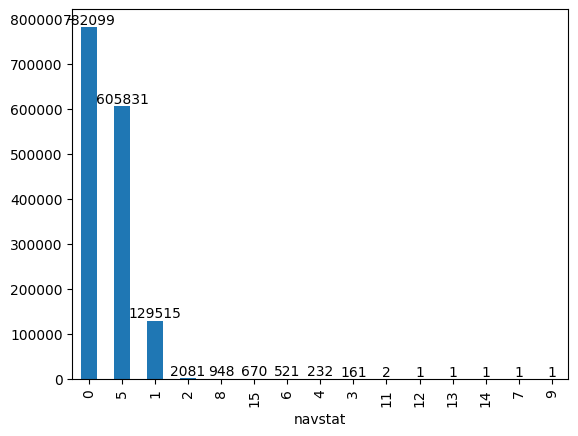

In [98]:
import matplotlib.pyplot as plt

train = pd.read_csv('../data/ais_train.csv', sep='|')


navstats = train['navstat']

# make a bar plot of the navstats. add the coints to the bars
navstats.value_counts().plot(kind='bar')
for i, v in enumerate(navstats.value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

In [66]:
X_train = np.load('../data/LSTM/X_train.npz')['arr_0']
y_train = np.load('../data/LSTM/y_train.npz')['arr_0']

In [72]:
print(X_train.shape)
print(y_train.shape)
print(X_train[0,-2:,:])
print("---------")
print(y_train[0,:])
print("---------")
print(X_train[1,-2:,:])

(1210487, 11, 62)
(1210487, 19)
[[8.035980e+00 7.690095e+01 3.075000e+02 1.610000e+01 1.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 6.500000e+03
  1.990000e+02 1.920000e+01 1.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 1.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 

In [107]:
a = pd.DataFrame({'spin': [3,4,5,4,3,3]})
a = pd.get_dummies(a['spin'], prefix='spin')
print(a)

# set all that have spin_5 to have spin_4 instead
a['spin_4'] = a['spin_4'] + a['spin_5']
a = a.drop('spin_5', axis=1)
print(a)

   spin_3  spin_4  spin_5
0    True   False   False
1   False    True   False
2   False   False    True
3   False    True   False
4    True   False   False
5    True   False   False
   spin_3  spin_4
0    True   False
1   False    True
2   False    True
3   False    True
4    True   False
5    True   False
